In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from copy import copy
from numpy.random import default_rng


In [2]:
def pol2cart(l, teta):
    
    x = l * np.cos(teta* np.pi /180)
    y = l * np.sin(teta* np.pi /180)
    
    return x, y

In [3]:
def all_convert(cart):  
    x_array=np.array([])
    y_array=np.array([])
    for i in range(len(cart)):
        x,y=pol2cart(cart[i][1],cart[i][0])
        x_array=np.hstack((x_array,x))
        y_array=np.hstack((y_array,y))
        
    return x_array,y_array

In [20]:
# zavie,fasele
carty=[[0,0.5197],[5,0.4404],[10,0.4850],[15,0.4222],[20,0.4132],[25,0.4371],[30,0.3912],[35,0.3949],[40,1.3910],[45,0.4276],[50,0.4075],[55,0.3956],[60,2.4053],[65,0.4752],[70,0.5032],[75,0.5273],[80,0.4879]]
# print(all_convert(carty))
x,y = all_convert(carty)


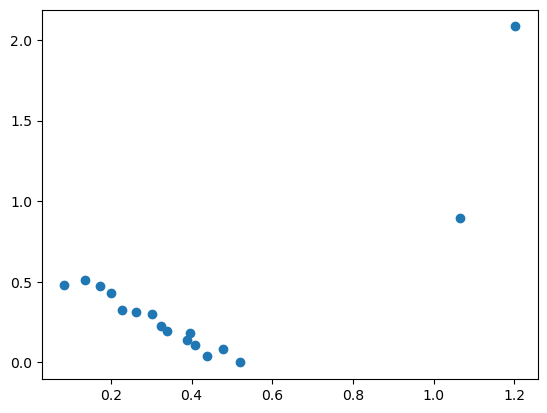

In [5]:
plt.scatter(x,y)
plt.show()

In [21]:
x_train=x.reshape((17,1))
y_train=y.reshape((17,1))


bias=np.ones((17,1))
x_train=np.append(bias,x_train,axis=1)

print(x_train)

[[1.         0.5197    ]
 [1.         0.43872415]
 [1.         0.47763176]
 [1.         0.40781388]
 [1.         0.38828099]
 [1.         0.39614713]
 [1.         0.33878914]
 [1.         0.32348314]
 [1.         1.06556782]
 [1.         0.30235886]
 [1.         0.26193595]
 [1.         0.22690684]
 [1.         1.20265   ]
 [1.         0.2008282 ]
 [1.         0.17210454]
 [1.         0.13647528]
 [1.         0.08472295]]


In [7]:
def update_weight(x_train,y_train):
    W = np.dot(np.dot(inv(np.dot(x_train.T,x_train)),x_train.T),y_train)
    return W

In [8]:
W = update_weight(x_train,y_train)

In [9]:
def forward_propagation(x,W):
    return  np.dot(W[1],x) + W[0]

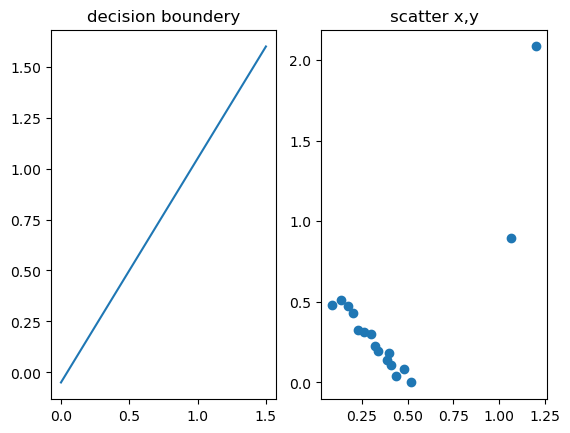

In [10]:
x_test = np.linspace(0, 1.5 , 100)
x_test=x_test.reshape((1,100))
y_trained=forward_propagation(x_test,W)
figure, axis = plt.subplots(1, 2)
axis[0].plot(x_test[0],y_trained )
axis[0].set_title("decision boundery")
axis[1].scatter(x,y )
axis[1].set_title("scatter x,y")
plt.show()


In [11]:
def square_error_loss(y_true, y_pred):
    return (y_true - y_pred) ** 2

In [12]:
def mean_square_error(y_true, y_pred):
    return np.sum(square_error_loss(y_true, y_pred)) / y_true.shape[0]

In [13]:
print('MSE for sudo inverse :'+str(mean_square_error(y_train.reshape(17,1), forward_propagation(x.reshape(1,17),W).reshape(17,1))))

MSE for sudo inverse :0.12057585388293435


In [14]:
rng = default_rng()

class RANSAC:
    def __init__(self, n=10, k=1000, t=0.05, d=10, model=None, loss=None, metric=None):
        
        self.n = n              
        self.k = k             
        self.t = t             
        self.d = d             
        self.model = model     
        self.loss = loss       
        self.metric = metric   
        self.best_fit = None
        self.best_error = np.inf

    def fit(self, X, y):

        for _ in range(self.k):
            ids = rng.permutation(X.shape[0])

            maybe_inliers = ids[: self.n]
            maybe_model = copy(self.model).fit(X[maybe_inliers], y[maybe_inliers])

            thresholded = (
                self.loss(y[ids][self.n :], maybe_model.predict(X[ids][self.n :]))
                < self.t
            )

            inlier_ids = ids[self.n :][np.flatnonzero(thresholded).flatten()]

            if inlier_ids.size > self.d:
                inlier_points = np.hstack([maybe_inliers, inlier_ids])
                better_model = copy(self.model).fit(X[inlier_points], y[inlier_points])

                this_error = self.metric(
                    y[inlier_points], better_model.predict(X[inlier_points])
                )

                if this_error < self.best_error:
                    self.best_error = this_error
                    self.best_fit = maybe_model

        return self

    def predict(self, X):
        return self.best_fit.predict(X)

In [15]:
class LinearRegressor:
    def __init__(self):
        self.params = None

    def fit(self, X: np.ndarray, y: np.ndarray):
        r, _ = X.shape
        X = np.hstack([np.ones((r, 1)), X])
        self.params = np.linalg.inv(X.T @ X) @ X.T @ y
        return self

    def predict(self, X: np.ndarray):
        r, _ = X.shape
        X = np.hstack([np.ones((r, 1)), X])
        return X @ self.params

In [16]:
regressor = RANSAC(model=LinearRegressor(), loss=square_error_loss, metric=mean_square_error)

In [17]:
x_train=np.append(x,x).reshape(-1,1)
y_train=np.append(y,y).reshape(-1,1)
regressor.fit(x_train,y_train)

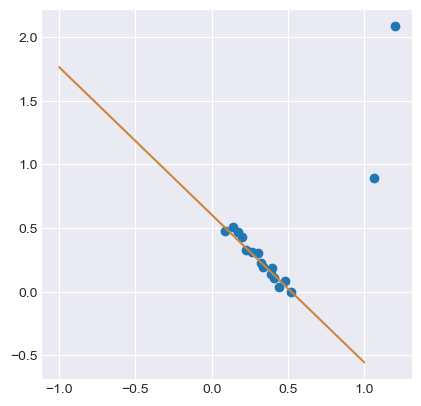

In [18]:
plt.style.use("seaborn-darkgrid")
fig, ax = plt.subplots(1, 1)
ax.set_box_aspect(1)

plt.scatter(x, y)

line = np.linspace(-1, 1, num=100).reshape(-1, 1)
plt.plot(line, regressor.predict(line), c="peru")
plt.show()

In [19]:
print('MSE for RANSAC :'+str(mean_square_error(y.reshape(17,1),regressor.predict(x.reshape(-1, 1)).reshape(17,1))))

MSE for RANSAC :0.6230943439018531
